In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from funkwpap import sympy_to_gurobi, Firm, Country, Sector, Regulator, get_emission
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt

In [2]:
x, y = sp.symbols('x y')
# Create Sectors and Countries
Regulator3 = Regulator('EU', permit_price= 2, emission_cap= 100)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator3)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator3)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator3)
country1 = Country('DE', 1, regulator= Regulator3)
country2 = Country('FI', 0.5, regulator= Regulator3)
country3 = Country('GR', size= 0.1, regulator= Regulator3)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 0.1*x**3 + 100/y**2, 0, 0, 0, regulator= Regulator3) 
firm2 = Firm('firm2', 1, 2, x*0, 5*x**3.2 + 40/y**2, 0, 0, 0, regulator= Regulator3)
firm3 = Firm('firm3', 1, 3, x*0, x**5.2 + 30/y**2, 0, 0, 0, regulator= Regulator3)
firm4 = Firm('firm4', 2, 1, x*0, x**3.3 + 20/y**2, 0, 0, 0, regulator= Regulator3)
firm5 = Firm('firm5', 2, 2, x*0, x**2.3 + 20/y**2, 0, 0, 0, regulator= Regulator3)
firm6 = Firm('firm6', 2, 3, x*0, x**3.2 + 15/y**2, 0, 0, 0, regulator= Regulator3)
firm7 = Firm('firm7', 3, 1, x*0, x**4.1 + 40/y**2, 0, 0, 0, regulator= Regulator3)
firm8 = Firm('firm8', 3, 2, x*0, x**5.1 + 50/y**2, 0, 0, 0, regulator= Regulator3)
firm9 = Firm('firm9', 3, 3, x*0, x**5 + 60/y**2, 0, 0, 0, regulator= Regulator3)


print(sector1.firms)  # List of firms in sector1
print(country1.firms)  # List of firms in country1
print(Regulator3.firm_registry)  # Dictionary of all firms

for firm in Regulator3.firm_registry.values():
    print(firm.name, firm.sector.name, firm.country.name)

[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0)]
[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=7, name='firm7', sector_id=3, country_id=1, actual_output=0, emission=0, profit=0)]
{1: Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), 2: Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), 3: Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0), 4: Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), 5: Firm(id=5, name='firm5', sector_id=2, country_id=2, actual_out

In [3]:
# Read a csv file that has the column names in the first row and some entries are lists of floats which are writeen inside double quotes to seperate those commas from the commans of the scv file. 
with open ('../data/generated/exp3_how_Free_allocation_of_one_sector_affects_others_v0_1.csv', 'r') as f:
    df = pd.read_csv(f)

print(df)

    Free Allocation  Emission Cap  Permit Price  \
0          0.000000   1792.357703     26.226044   
1          0.010101   1792.357703     26.702881   
2          0.020202   1792.357703     26.702881   
3          0.030303   1792.357703     27.179718   
4          0.040404   1792.357703     27.656555   
..              ...           ...           ...   
95         0.959596   1792.357703     44.822693   
96         0.969697   1792.357703     44.822693   
97         0.979798   1792.357703     44.822693   
98         0.989899   1792.357703     44.822693   
99         1.000000   1792.357703     45.776367   

                                              Outputs  \
0   (176.04523429126368, 187.54290076821835, 187.5...   
1   (176.04523429126368, 187.54290076821835, 187.5...   
2   (176.04523429126368, 187.54290076821835, 187.5...   
3   (187.54290076821835, 176.04523429126368, 187.5...   
4   (176.04523429126368, 187.54290076821835, 187.5...   
..                                           

In [4]:

Sales = []
Abatements = []
Trades = []
Outputs = []
Emissions = []
Profits = []
for i in range(len(df)):
    Regulator3.emission_cap = df['Emission Cap'][i]
    Regulator3.permit_price = df['Permit Price'][i]
    out = df['Outputs'][i].replace('(','').replace(')','').split(',')
    em = df['Emissions'][i].replace('(','').replace(')','').split(',')
    pr = df['Profits'][i].replace('(','').replace(')','').split(',')
    sal = []
    abat = []
    trad = []


    for firm in Regulator3.firm_registry.values():
        firm.actual_output = float(out[firm.id-1])
        firm.emission = float(em[firm.id-1])
        firm.profit = float(pr[firm.id-1])
        sal.append(firm.calculate_sales())
        abat.append(firm.calculate_abatement())
        trad.append(firm.calculate_trading())
    Sales.append(sal)
    Abatements.append(abat)
    Trades.append(trad)
    Outputs.append(out)
    Emissions.append(em)
    Profits.append(pr)
print(Trades)

# Combine all the data back into one dataframe
df['Sales'] = Sales
df['Abatements'] = Abatements
df['Trades'] = Trades
df['Outputs'] = Outputs
df['Emissions'] = Emissions
df['Profits'] = Profits
print(df)

# go through the columns "Sales", "Abatements", "Trades", "Outputs", "Emissions", "Profits" and convert the list of strings to list of floats
for col in ["Sales", "Abatements", "Trades", "Outputs", "Emissions", "Profits"]:
    for i in range(len(df)):
        df[col][i] = [float(x) for x in df[col][i]]


[[4471.49371520585, 4885.25324135517, 4879.65191332593, 8094.20880763794, 7992.40816843555, 8091.62256398521, 2786.38890699799, 2796.73676820053, 2789.61289213543], [4552.79360093686, 4974.07602756163, 4968.37285720459, 8241.37624050409, 8128.70959785728, 8236.38541636160, 2822.70071300296, 2835.34727405755, 2845.28673787841], [4552.79360093686, 4974.07602756163, 4968.37285720459, 8241.37624050409, 8128.70959785728, 8236.38541636160, 2822.68067248021, 2830.46893046521, 2848.51139072383], [4944.16505672785, 4750.39548106430, 5057.09380108324, 8388.54367337023, 8273.86512639044, 8383.46372736806, 2879.40951504295, 2885.43712103828, 2875.90472887235], [4712.91894725255, 5151.72159997454, 5145.81474496189, 8005.95562680758, 8419.02065492361, 8530.54203837451, 2916.45788745520, 2930.79569809196, 2929.11718621875], [4712.91894725255, 5151.72159997454, 5145.81474496189, 8005.95562680758, 8419.02065492361, 8530.54203837451, 2916.70147399040, 2927.99141232888, 2930.96203566923], [5030.904794565

C:\Users\Kostas\AppData\Local\Temp\ipykernel_20096\833349061.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[col][i] = [float(x) for x in df[col][i]]
C:\Users\Kostas\AppData\Local\Temp\ipykernel_20096\833349061.py:45: SettingWithCopy

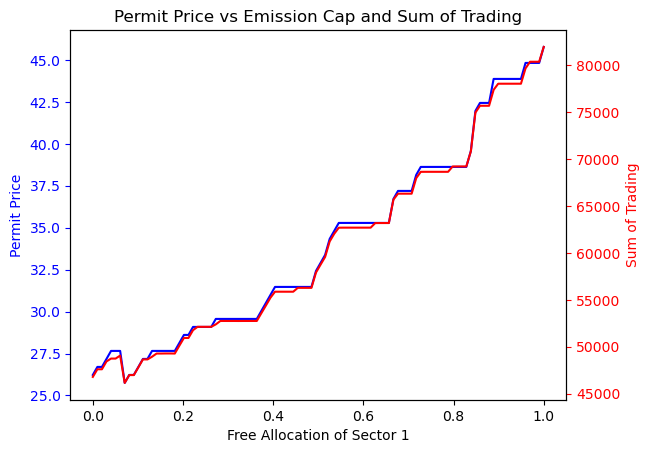

In [5]:


# Plot the permit price against the emission cap
fig, ax1 = plt.subplots()

ax1.plot(df['Free Allocation'][0:], df['Permit Price'][0:], 'b-')
ax1.set_xlabel('Free Allocation of Sector 1')
ax1.set_ylabel('Permit Price', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis
ax2 = ax1.twinx()
trading_sums = [sum(trading) for trading in df['Trades']]
ax2.plot(df['Free Allocation'][0:], trading_sums, 'r-')
ax2.set_ylabel('Sum of Trading', color='r')
ax2.tick_params('y', colors='r')

plt.title('Permit Price vs Emission Cap and Sum of Trading')
plt.show()

   

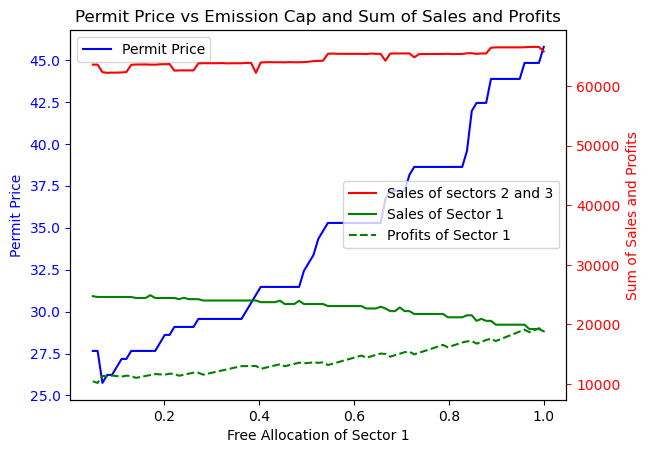

In [11]:
import matplotlib.pyplot as plt

first_element_to_plot = 5

# Plot the permit price against the emission cap
fig, ax1 = plt.subplots()

ax1.plot(df['Free Allocation'][first_element_to_plot:], df['Permit Price'][first_element_to_plot:], 'b-', label='Permit Price')
ax1.set_xlabel('Free Allocation of Sector 1')
ax1.set_ylabel('Permit Price', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis
ax2 = ax1.twinx()
sales_sums = [sum(sales[4:]) for sales in df['Sales']]
sales_sum_of_sector_1 = [sum(sales[0:3]) for sales in df['Sales']]
profits_of_sector_1 = [sum(profits[0:3]) for profits in df['Profits']]  # Assuming df['Profits'] contains the profit data

ax2.plot(df['Free Allocation'][first_element_to_plot:], sales_sums[first_element_to_plot:], 'r-', label='Sales of sectors 2 and 3')
ax2.plot(df['Free Allocation'][first_element_to_plot:], sales_sum_of_sector_1[first_element_to_plot:], 'g-', label='Sales of Sector 1')
ax2.plot(df['Free Allocation'][first_element_to_plot:], profits_of_sector_1[first_element_to_plot:], 'g--', label='Profits of Sector 1')  # Green dashed line for profits

ax2.set_ylabel('Sum of Sales and Profits', color='r')
ax2.tick_params('y', colors='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='best')

plt.title('Permit Price vs Emission Cap and Sum of Sales and Profits')
plt.show()